<a href="https://colab.research.google.com/github/markkod/pc3-enzymes/blob/main/Kernels_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
## Group 8
#### Graph Property Prediction



## Setup



Cloning the git repo, installing matching pytorch addons, building C++ bindings

In [1]:
# %%capture output

# Script to generate variations of the kernels yourself
# https://ucloud.univie.ac.at/index.php/s/E3YKph0jkpbw8TN


# #Download the TUDataset Repository with
!git clone https://github.com/chrsmrrs/tudataset.git
# #move this script to tudataset/tud_benchmark

# Make sure that the matching version of torch is used
import torch
version = torch.__version__.split('+')[0]

# #Install pytorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# #Here is the gpu cuda installation, for the cpu version replace cu102 with cpu
%pip --no-cache-dir install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-{version}.html
%pip --no-cache-dir install torch-geometric

%pip --no-cache-dir install pybind11
!sudo apt-get install libeigen3-dev

%cd ..
%cd /content/tudataset/tud_benchmark/kernel_baselines/
! ls
! g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`
%cd ..

Cloning into 'tudataset'...
remote: Enumerating objects: 485, done.
remote: Counting objects: 100% (485/485), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 3344 (delta 244), reused 300 (delta 114), pack-reused 2859
Receiving objects: 100% (3344/3344), 8.47 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 9.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 10.6MB/s 
     |████████████████████████████████| 194kB 9.1MB/s 
     |████████████████████████████████| 235kB 17.1MB/s 
     |████████████████████████████████| 

Handling the imports

In [2]:
import os
import torch
import numpy as np
import kernel_baselines as kb
import auxiliarymethods
from auxiliarymethods import datasets as dp
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from scipy.sparse import csr_matrix
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation as ke
from auxiliarymethods.reader import tud_to_networkx
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict
from pprint import pprint
import random
import pandas as pd
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

Utility methods for data loading and graph visualization



In [3]:
def setup_directory(dir_name, verbose=False):
    """
    Setup directory in case it does not exist
    Parameters:
    -------------
    dir_name: str, path + name to directory
    verbose: bool, indicates whether directory creation should be printed or not.
    """
    if not os.path.exists(dir_name):
        try:
            os.makedirs(dir_name)
            if verbose:
                print("Created Directory: {}".format(dir_name))
        except Exception as e:
            raise RuntimeError(
                "Could not create directory: {}\n {}".format(dir_name, e))


def load_csv(path):
    return np.loadtxt(path, delimiter=";")


def load_sparse(path):
    return load_npz(path)


def select_from_list(l, indices):
    return [l[i] for i in indices]


def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show()


def find_keys_with_condition(data, cond):
    return list(filter(lambda x: cond in x, data.keys()))


def load_data():
  result = {}
  extensions = ['csv', 'npz']
  types = ['gram_matrix', 'vectors']
  algos = ['wl1', 'wl2', 'wl3', 'wl4', 'wl5', 'wl6', 'wl7', 'wl8', 'shortestpath', 'graphlet']
  base_name = '/content/tudataset/tud_benchmark/kernels/node_labels/ENZYMES_{0}_{1}.{2}'

  for t, e in zip(types, extensions):
    result[t] = {}
    for a in algos:
      algo_name = 'wl' if 'wl' in a else a

      if algo_name not in result[t].keys():
        result[t][algo_name] = []

      file_name = base_name.format(t, a, e)

      if e == 'csv':
        f = np.loadtxt(file_name, delimiter=';')
      else:
        f = load_npz(file_name)
      
      result[t][algo_name].append(f)
  return result


Build the gram matrices

In [4]:
use_edge_labels = False
for USE_LABELS in [True, False]:
    for dataset, use_labels in [["ENZYMES", USE_LABELS]]:
        if use_labels:
            base_path = os.path.join("kernels","node_labels")
        else:
            base_path = os.path.join("kernels","without_labels")
        setup_directory(base_path)
        print("Start processing data set ", dataset)

        # Download dataset.
        classes = dp.get_dataset(dataset)

        # *Weisfeihler-Lehman*
        print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
        iterations = 9
        #0 taking just the nodelabels themselves into account; 
        #1 considers nearest-neighbours, 2 one layer deeper and so on
        for i in range(1, iterations):
            print("Start iteration ", i)
            #Gram Matrix for the Weisfeiler-Lehman subtree kernel
            gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
            np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                    gram_matrix_wl,
                    delimiter=";")
            #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
            vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
            save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                    vectors_wl, compressed=True)

        # *Graphlet kernel*
        print("Start computing Graphlet gram matrix")

        #Gram Matrix for the Graphlet kernel
        gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
                gram_matrix_graphlet,
                delimiter=";")

        print("Start computing Graphlet vector representation")
        #Sparse Vectors for the Graphlet kernel
        vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
                vectors_graphlet, compressed=True)


        print("Start computing Shortest path gram matrix")

        #Gram Matrix for the Shortest path kernel
        gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
                gram_matrix_shortestpath,
                delimiter=";")

        print("Start computing Shortest path vector representation")

        #Sparse Vectors for the Shortest path kernel
        vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
                vectors_shortestpath, compressed=True)


Start processing data set  ENZYMES
Extracting /content/tudataset/tud_benchmark/datasets/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation


Loading the data and previewing the format

In [5]:
base_path = os.path.join("kernels", "node_labels")
ds_name = "ENZYMES"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 600
Number of classes 6


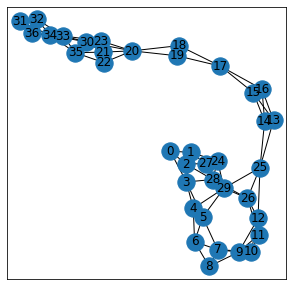

In [6]:
visualize(G[0])

Load the entire dataset of the gram matrices from the base kernels


In [7]:
data = load_data()

## Kernel evaluation

In [9]:
def eval_kernel(kernel, classes, mode, n_reps=10, all_std=True):
  normalized = []
  print(f'Starting normalization of {len(kernel)} elements...')
  for array in kernel:
    if mode == 'LINEAR':
      normalized.append(aux.normalize_feature_vector(array))
    else:
      normalized.append(aux.normalize_gram_matrix(array))
  print(f'Normalization finished, starting {mode} SVM...')
  if mode == 'LINEAR':
    return ke.linear_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)
  return ke.kernel_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)


def eval_all(data):
  classes = dp.get_dataset('ENZYMES')
  result = {}
  for data_type in data.keys():
    mode = 'LINEAR' if data_type == 'vectors' else 'KERNEL'
    result[data_type] = {}
    print('MODE:', mode)
    for kernel in data[data_type]:
      print(f'\nEvaluating {kernel} SVM...')
      result[data_type][kernel] = eval_kernel(data[data_type][kernel], classes, mode)
      print(f'{data_type}-{kernel} : {result[data_type][kernel]}')
  return result

### Baseline kernels

In [ ]:
results = eval_all(data)

MODE: KERNEL

Evaluating wl SVM...
Starting normalization of 8 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-wl : (50.08333333333333, 2.187400791401114, 7.289166237948236)

Evaluating shortestpath SVM...
Starting normalization of 1 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-shortestpath : (39.88333333333333, 1.2088791870525735, 5.638434573926034)

Evaluating graphlet SVM...
Starting normalization of 1 elements...
Normalization finished, starting KERNEL SVM...
gram_matrix-graphlet : (29.81666666666667, 0.9263128821060183, 5.238187769745479)
MODE: LINEAR

Evaluating wl SVM...
Starting normalization of 8 elements...
Normalization finished, starting LINEAR SVM...
